In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from datetime import datetime, timedelta
import time
import os
from forex_python.converter import CurrencyRates


import warnings
warnings.filterwarnings('ignore')

In [259]:
df = pd.read_csv('Booking_hotels.csv')

In [260]:
df.head()

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06 11:24:01.241227,1,Margaritaville Resort Times Square,0,1,8.8,"1,369 reviews",₪ 752,₪ 752,1.5 km from center,Standard Queen Room,Location 9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06 11:24:01.241227,2,33 Seaport Hotel New York,0,1,8.6,284 reviews,"₪ 1,050\r\nPrice ₪ 1,050","₪ 1,050\r\nPrice ₪ 1,050",6.9 km from center,Superior Courtyard King,NaN,Superior Courtyard King\r\n1 king bed
2,2023-03-06 11:24:01.241227,3,The Belvedere Hotel,0,1,8.0,"3,644 reviews",₪ 510,₪ 510,0.9 km from center,Standard King Room,Location 9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06 11:24:01.241227,4,CIVILIAN Hotel,0,1,8.5,"1,172 reviews",₪ 767,₪ 767,0.9 km from center,Double Room,Location 9.5,Double Room\r\n1 queen bed
4,2023-03-06 11:24:01.241227,5,The Cloud One New York-Downtown,0,1,8.2,518 reviews,₪ 620,₪ 620,7 km from center,Standard King Room,NaN,Standard King Room\r\n1 king bed\r\nFREE cance...


In [261]:
# extracting numeric data and removing useless text from prices, location grade, and review. normalize distance from center to m' instead of km, and inserts -1 instead of NaNs

df = pd.read_csv('Booking_hotels.csv')
df[['del', 'Curr Price']] = df['Curr Price'].str.split(' ', 1, expand = True)
df[['Curr Price','del2']] = df['Curr Price'].str.split(r"\r", 0, expand = True)
df[['del', 'Original Price']] = df['Original Price'].str.split(' ', 1, expand = True)
df[['Original Price','del2']] = df['Original Price'].str.split(r"\r", 0, expand = True)
df[['Num of Reviews', 'del']] = df['Num of Reviews'].str.split(' ', 1, expand = True)

df['Distance from center'] = df['Distance from center'].apply(lambda a: int(float(a.split(' ')[0])*1000) if a.split(' ')[1] == 'km' else int(a.split(' ')[0]))
df[['del', 'Location grade']] = df['Location grade'].str.split(' ', 1, expand = True)
df['Location grade'] = df['Location grade'].apply(lambda a: -1 if pd.isna(a) else a)

df = df.drop(columns=['del', 'del2'])


In [262]:
# from datetime to date

df['Snapshot'] = pd.to_datetime(df['Snapshot']).dt.date
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",752,752,1500,Standard Queen Room,9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,"1,050","1,050",6900,Superior Courtyard King,-1,Superior Courtyard King\r\n1 king bed
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",510,510,900,Standard King Room,9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",767,767,900,Double Room,9.5,Double Room\r\n1 queen bed
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,620,620,7000,Standard King Room,-1,Standard King Room\r\n1 king bed\r\nFREE cance...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2023-03-08,96,Pestana CR7 Times Square,29,5,8.1,"1,365","4,872","5,128",1600,Comfort Plus,-1,Comfort Plus\r\n1 queen bed\r\nFree cancellati...
29996,2023-03-08,97,M Social Hotel Times Square New York,29,5,8.4,"5,569","6,028","6,698",600,Social City View King,9.6,Social City View King\r\n1 king bed
29997,2023-03-08,98,Hilton Garden Inn West 35th Street,29,5,8.3,"2,497","6,465","6,465",2000,King Room,9.5,King Room\r\n1 king bed\r\nFREE cancellation •...
29998,2023-03-08,99,Wyndham Garden Chinatown,29,5,7.6,616,"4,325","4,325",5800,Superior Queen Room Non-Smoking,-1,Superior Queen Room Non-Smoking\r\n1 queen bed...


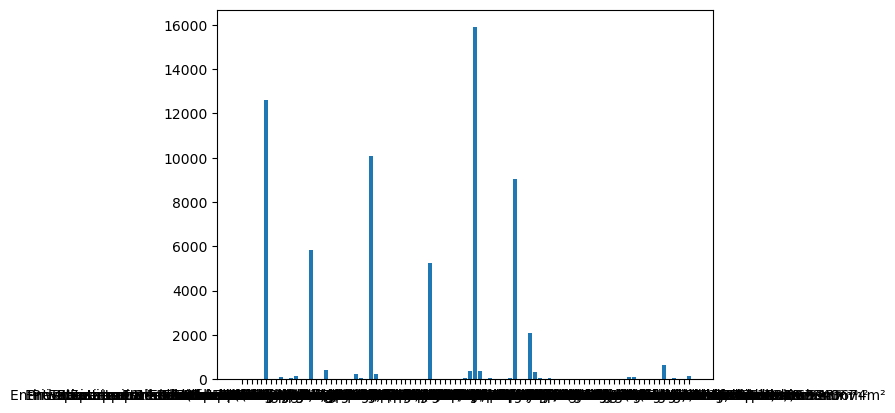

In [263]:
#breaking down 'Extra Data' to categories

op_set = set()
#row = df.head(1)
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_set.add(item)

op_list = []
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_list.append(item)

op_dict = {}
for set_item in op_set:
    count = 0
    for list_item in op_list:
        if list_item == set_item:
            count = count + 1
            
    op_dict[set_item] = count 

names = list(op_dict.keys())
values = list(op_dict.values())

plt.bar(range(len(op_dict)), values, tick_label=names)
plt.show()

In [264]:
# focusing on top categories, ignoring bed count and other generic cats
sorted(op_dict.items(), key=lambda x: x[1], reverse=True)

[('FREE cancellation • No prepayment needed', 15891),
 ('1 king bed', 12594),
 ('You can cancel later, so lock in this great price today!', 10067),
 ('1 queen bed', 9022),
 ('Breakfast included', 5816),
 ('Free cancellation', 5264),
 ('1 full bed', 2087),
 ('2 full beds', 649),
 ('2 beds (1 king, 1 sofa bed)', 400),
 ('Private suite', 381),
 ('1 bunk bed', 379),
 ('2 twin beds', 306),
 ('2 queen beds', 241),
 ('Entire studio • 1 bathroom • 19m²', 219),
 ('Entire studio • 1 bathroom • 25m²', 128),
 ('2 beds (1 sofa bed, 1 queen)', 127),
 ('Entire studio • 1 bathroom • 325m²', 93),
 ('1 twin bed', 92),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 28m²', 87),
 ('Entire studio • 1 bathroom • 18m²', 70),
 ('Entire studio • 1 bathroom • 20m²', 69),
 ('Entire studio • 1 bathroom • 28m²', 65),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²', 63),
 ('4 twin beds', 62),
 ('Beds: 1 double or 2 twins', 55),
 ('3 beds (2 fulls, 1 sofa bed)', 48),
 ('Entire studio • 

In [265]:
# combining cats for free cancelation and comparing counts
cancellation_count = 0
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    if ('FREE cancellation • No prepayment needed' in line_list) or ('Free cancellation' in line_list):
        cancellation_count = cancellation_count + 1
        
print(cancellation_count)

df['Free Cancellation'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) 
                                                 or ('Free cancellation' in a.split('\r\n')) else False)
df.groupby('Free Cancellation').count()

21155


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
Free Cancellation,,,,,,,,,,,,,
False,8845,8845,8845,8845,8845,8845,8845,8845,8845,8845,8845,8845,8845
True,21155,21155,21155,21155,21155,21155,21155,21155,21155,21155,21155,21155,21155


In [266]:
# converting top categories to bool

df['No prepayment needed'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) else False)
df['Breakfast included'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('Breakfast included' in a.split('\r\n')) else False)
df['Cancel Later'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('You can cancel later, so lock in this great price today!' in a.split('\r\n')) else False)
df = df.drop(columns=['Extra Data'])

In [267]:
#converting ILS to USD for comparison to expedia
c = CurrencyRates()
x = df['Snapshot'].unique()
curr_dict = {}
for date in x:
    print()
    curr_dict[date] = c.get_rate('ILS','USD', date)


In [268]:
df['Original Price'] = df['Original Price'].apply(lambda x: int(x.replace(',','')))
df['Curr Price'] = df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [269]:
df['Original Price'] = df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
df['Curr Price'] = df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)

In [270]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2023-03-08,96,Pestana CR7 Times Square,29,5,8.1,"1,365",272.431884,286.746860,1600,Comfort Plus,-1,True,False,False,True
29996,2023-03-08,97,M Social Hotel Times Square New York,29,5,8.4,"5,569",337.072947,374.537923,600,Social City View King,9.6,False,False,False,False
29997,2023-03-08,98,Hilton Garden Inn West 35th Street,29,5,8.3,"2,497",361.509058,361.509058,2000,King Room,9.5,True,True,False,True
29998,2023-03-08,99,Wyndham Garden Chinatown,29,5,7.6,616,241.844807,241.844807,5800,Superior Queen Room Non-Smoking,-1,True,False,False,True


(array([4420., 3322., 3887., 3687., 1537., 3797., 3379., 2560., 1981.,
        1430.]),
 array([  0. ,  62.7, 125.4, 188.1, 250.8, 313.5, 376.2, 438.9, 501.6,
        564.3, 627. ]),
 <BarContainer object of 10 artists>)

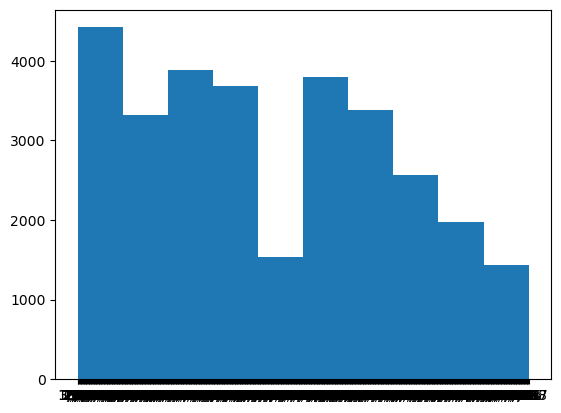

In [271]:
plt.hist(df['Num of Reviews'])

(array([3.2000e+02, 1.1100e+02, 8.5100e+02, 1.7120e+03, 4.0670e+03,
        9.4680e+03, 1.0109e+04, 3.1170e+03, 2.3900e+02, 6.0000e+00]),
 array([ 5.4 ,  5.86,  6.32,  6.78,  7.24,  7.7 ,  8.16,  8.62,  9.08,
         9.54, 10.  ]),
 <BarContainer object of 10 artists>)

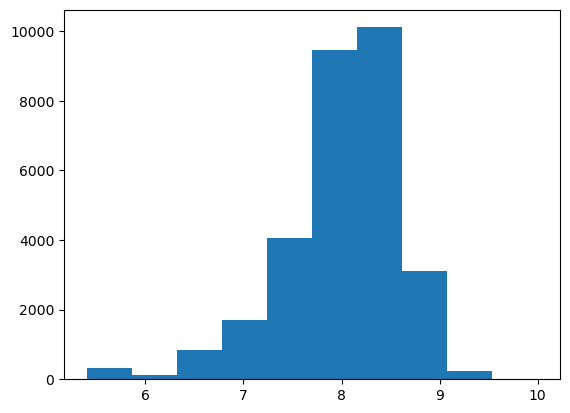

In [272]:
plt.hist(df['Grade'])

(array([2.881e+03, 1.308e+04, 9.848e+03, 3.168e+03, 7.180e+02, 1.840e+02,
        4.600e+01, 4.300e+01, 5.000e+00, 2.700e+01]),
 array([  83.87681159,  185.28387681,  286.69094203,  388.09800725,
         489.50507246,  590.91213768,  692.3192029 ,  793.72626812,
         895.13333333,  996.54039855, 1097.94746377]),
 <BarContainer object of 10 artists>)

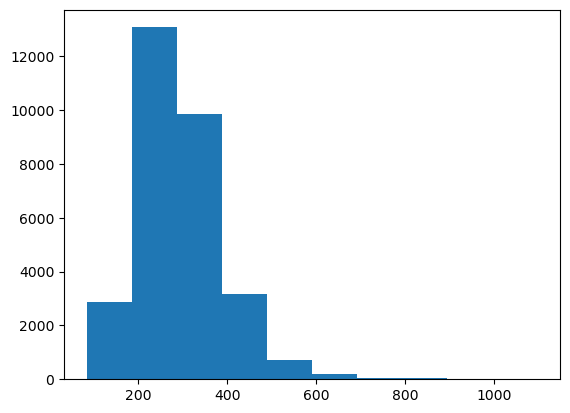

In [273]:
plt.hist(df['Curr Price'])

In [280]:
q1 = df['Curr Price'].quantile(0.25)
q3 = df['Curr Price'].quantile(0.75)
iqr = q3-q1
top_lim = q3 + 1.5*iqr
bottom_lim = q1 - 1.5* iqr
df = df.drop(df[df['Curr Price'] > top_lim].index)
df = df.drop(df[df['Curr Price'] < bottom_lim].index)


{'whiskers': [<matplotlib.lines.Line2D at 0x1e214175a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1e214177340>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e214175790>],
 'medians': [<matplotlib.lines.Line2D at 0x1e2141779a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e214177c40>],
 'means': []}

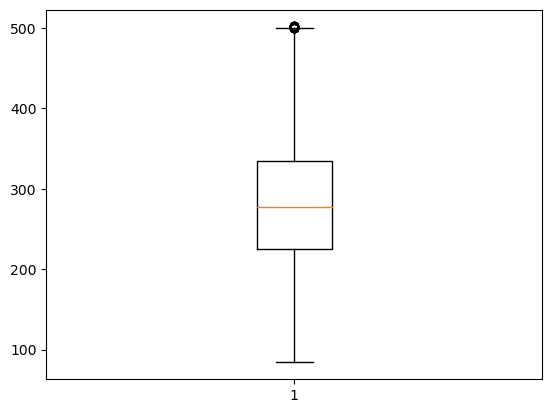

In [281]:
plt.boxplot(df['Curr Price'])

In [282]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2023-03-08,96,Pestana CR7 Times Square,29,5,8.1,"1,365",272.431884,286.746860,1600,Comfort Plus,-1,True,False,False,True
29996,2023-03-08,97,M Social Hotel Times Square New York,29,5,8.4,"5,569",337.072947,374.537923,600,Social City View King,9.6,False,False,False,False
29997,2023-03-08,98,Hilton Garden Inn West 35th Street,29,5,8.3,"2,497",361.509058,361.509058,2000,King Room,9.5,True,True,False,True
29998,2023-03-08,99,Wyndham Garden Chinatown,29,5,7.6,616,241.844807,241.844807,5800,Superior Queen Room Non-Smoking,-1,True,False,False,True
